In [1]:
import os

import pandas as pd
import numpy as np
from numpy import array
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import plotly.express as px
import plotly.graph_objects as go
from scipy.ndimage import zoom

import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

import warnings 
warnings.filterwarnings(action='ignore')

import scipy.stats
from scipy.stats import norm,t

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [2]:
line_type = {'solid line' : 'solid', ## 라인 유형
             'dashed line' : 'dashed',
             'dash-dotted line' : 'dashdot',
             'dotted line' : 'dotted'}

In [3]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [4]:
pd.set_option('display.max_columns', None)
trend = pd.read_csv('TEU분해.csv')
trend['Date'] = pd.to_datetime(trend['Date'])
trend = trend.set_index('Date')
print(trend.shape)
trend.head()

(60, 1)


,TEU_Trend
Date,
2017-07-31,2291408.583
2017-08-31,2302073.625
2017-09-30,2310450.375
2017-10-31,2312407.958
2017-11-30,2320814.042


In [5]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
data.head()

(270, 10)


,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.913430,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88
2000-02-29,590400,1531,1.986905,2.882456,4.005537,51.9,-324.1,1128.80,218300,130.56
2000-03-31,665430,1660,2.050943,2.884831,4.038299,58.7,275.3,1117.19,206116,128.19
2000-04-30,603930,1628,2.107499,2.887110,4.030758,56.9,-1156.0,1109.76,166931,126.84
2000-05-31,683880,1566,2.158143,2.890466,4.022112,59.6,1535.5,1120.01,208853,127.89


In [6]:
split = -60
train_data = data['TEU'][0:split] 
test_data = data['TEU'][split:]

In [7]:
train_data.shape,test_data.shape

((210,), (60,))

In [8]:
seasonal = pd.read_csv('계절성예측.csv')
print(seasonal.shape)

(60, 1)


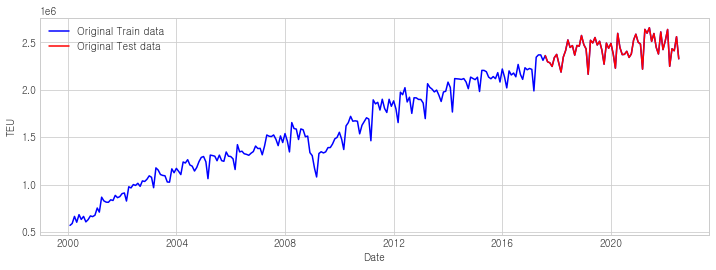

In [9]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='Original Train data')
plt.plot(test_data, 'red', label='Original Test data')
plt.legend()

### 2. 다변량 LSTM

In [10]:
import tensorflow 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense,Flatten,Dropout,GRU,Bidirectional,RepeatVector,TimeDistributed

In [11]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [12]:
import random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [13]:
tf.random.uniform([1]).numpy()

array([0.5380393], dtype=float32)

In [14]:
raw_df = data

In [15]:
split = -78
train = raw_df[0:split] 
test = raw_df[split:] 

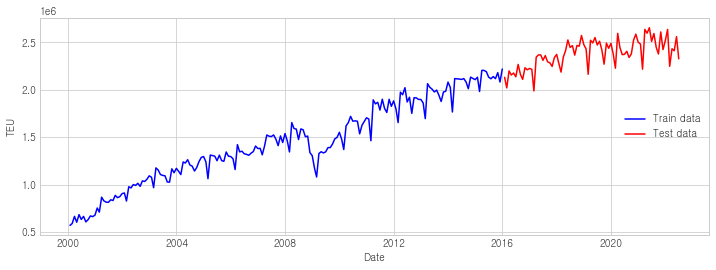

In [16]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(train['TEU'], 'blue', label='Train data')
plt.plot(test['TEU'], 'red', label='Test data')
plt.legend(loc=5)

In [17]:
len(train),len(test)

(192, 78)

In [18]:
data.columns

Index(['TEU', 'BDI', 'ln(HRCI)', 'ln(SCFI)', 'ln(다우존스지수)', '전산업생산지수', '경상수지',
       '환율', '화물수송총괄', '수출물가지수'],
      dtype='object')

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scale_cols =  ['TEU','BDI', 'ln(HRCI)', 'ln(SCFI)','수출물가지수','환율','전산업생산지수','경상수지','ln(다우존스지수)','화물수송총괄']
scaled_train = scaler.fit_transform(train[scale_cols])  
scaled_train = pd.DataFrame(scaled_train, columns=scale_cols)

feature_train = scaled_train                       # X_train 다변량 시계열 변수 
label_train = scaled_train[['TEU']]               #  y_train 종속변수 

scaled_test = scaler.fit_transform(test[scale_cols]) 
scaled_test = pd.DataFrame(scaled_test, columns=scale_cols)

feature_test = scaled_test                       # X_test 다변량 시계열 변수 
label_test = scaled_test[['TEU']]               #  y_test종속변수 

In [20]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [21]:
window_size = 18 # Input Sequence (입력 길이) : X1,X2,....XT 
n_step_out = 12   # Output Sequence (출력 길이) : Y1,Y2,....YT

### 1. X_train, Y_train 배열

In [22]:
X_train,y = split_sequence(feature_train, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_train = split_sequence(label_train, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [23]:
X_train.shape,Y_train.shape

((163, 18, 10), (163, 12, 1))

### 2. X_test,Y_test 배열

In [24]:
X_test,y = split_sequence(feature_test, window_size, n_step_out) # feature_test= X 다변량 변수 
x, Y_test = split_sequence(label_test, window_size, n_step_out) # label_test= Y 종속변수 예측값 

In [25]:
X_test.shape,Y_test.shape

((49, 18, 10), (49, 12, 1))

In [26]:
class MCDropout(Dropout): # 몬테카를로 드롭아웃 
    def call(self, inputs):
        return super().call(inputs, training=True)

In [27]:
from tcn import TCN, tcn_full_summary

In [28]:
model = Sequential() # Encoder & Decoder

## Encoder state
model.add(TCN(nb_filters=48,kernel_size=2,activation='tanh',padding='causal',input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=False))
model.add(MCDropout(0.8))
model.add(Dense(1))
model.add(RepeatVector(12)) # 출력 개수만큼 반복 

## Decoder State
model.add(TCN(nb_filters=48, activation='tanh', return_sequences=True)) # Decoder State 
model.add(MCDropout(0.8))
model.add(TimeDistributed(Dense(8,activation='tanh'))) 
model.add(TimeDistributed(Dense(1)))

model.compile(loss='mean_squared_error', optimizer='adam',metrics='mae')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, Y_train, epochs= 200, batch_size=10, validation_split=0.02,callbacks=[early_stop])

Epoch 1/200
16/16 [==============================] - 8s 240ms/step - loss: 1.1650 - mae: 0.8476 - val_loss: 0.6226 - val_mae: 0.6069
Epoch 2/200
16/16 [==============================] - 0s 22ms/step - loss: 0.4587 - mae: 0.5300 - val_loss: 0.4024 - val_mae: 0.4959
Epoch 3/200
16/16 [==============================] - 0s 21ms/step - loss: 0.2767 - mae: 0.4178 - val_loss: 0.3160 - val_mae: 0.4534
Epoch 4/200
16/16 [==============================] - 0s 21ms/step - loss: 0.2780 - mae: 0.4066 - val_loss: 0.3142 - val_mae: 0.4717
Epoch 5/200
16/16 [==============================] - 0s 21ms/step - loss: 0.1730 - mae: 0.3202 - val_loss: 0.2625 - val_mae: 0.4326
Epoch 6/200
16/16 [==============================] - 0s 21ms/step - loss: 0.1408 - mae: 0.2945 - val_loss: 0.2625 - val_mae: 0.4297
Epoch 7/200
16/16 [==============================] - 0s 23ms/step - loss: 0.1144 - mae: 0.2636 - val_loss: 0.6578 - val_mae: 0.6550
Epoch 8/200
16/16 [==============================] - 0s 21ms/step - loss: 0

In [29]:
rcParams['figure.figsize'] = 12, 4

<AxesSubplot:>

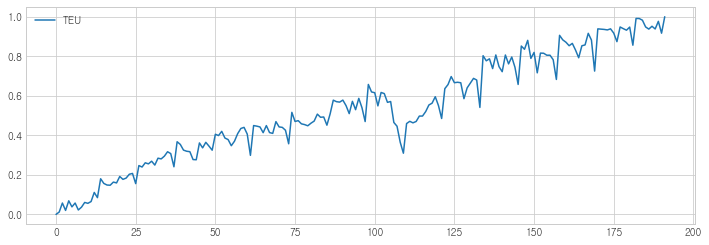

In [30]:
label_train.plot()

<AxesSubplot:>

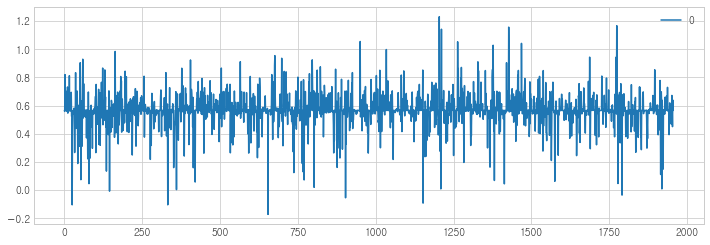

In [31]:
pd.DataFrame(model.predict(X_train).reshape(-1,1)).plot()

#### Most Probable Explanation

### 1. 2017.07 ~ 2018.06

In [32]:
X_test_1 = np.array(feature_test.head(18)).reshape((1, 18, 10)) 

In [33]:
model_MC=  model
prediction = [model_MC.predict(X_test_1) for sample in range(30)]

In [34]:
dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)

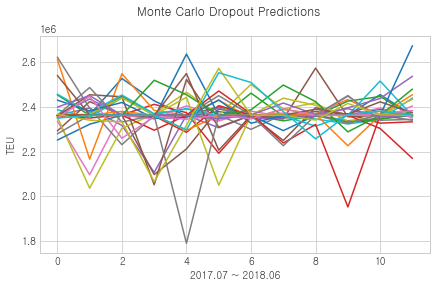

In [35]:
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2017.07 ~ 2018.06')
plt.ylabel('TEU')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [36]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])

In [37]:
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [38]:
np.mean(df.std()/df.mean())

0.03161587938666344

In [39]:
rmse = math.sqrt(mean_squared_error(trend[0:12].reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[0:12].reset_index()['TEU_Trend']- df.transpose().mean())/ trend[0:12].reset_index()['TEU_Trend'])*100) )

RMSE: 42860.903289265836
MAPE: 1.5178561498251444


In [40]:
rmse = math.sqrt(mean_squared_error(trend[0:12].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[0:12].reset_index()['TEU_Trend']- df.transpose().median())/ trend[0:12].reset_index()['TEU_Trend'])*100) )

RMSE: 41488.98479586437
MAPE: 1.5515929976099196


In [41]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[:12]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-31,2359652.25,2352290.0,2453332.5,2362217.5,2362558.75,2292109.25,2336172.5,2622740.0,2354723.25,2386968.25,2251245.0,2613073.75,2362588.75,2358859.0,2362408.5,2359517.25,2361350.5,2362528.0,2362561.25,2456758.25,2430261.25,2360416.75,2362561.0,2362047.0,2398810.75,2540647.0,2349348.0,2278855.0,2365987.5,2349312.0


In [42]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:222]
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2018-06-30,2443990,1385,2.926085,2.901474,4.385095,110.3,7980.1,1092.8,137274768,103.55


In [43]:
df.to_csv('TCN.csv')

Mean RMSE: 87336.90860499405
Mean MAPE: 3.1173136990820502


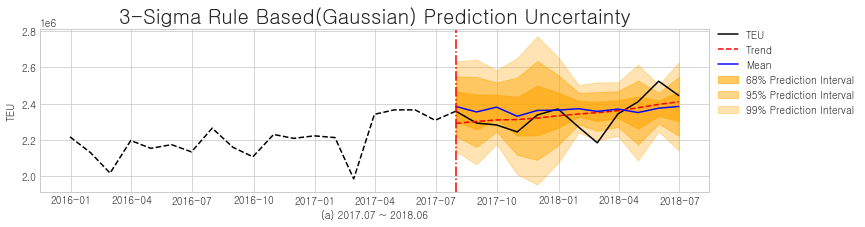

In [44]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2018.06')
plt.ylabel('TEU')
plt.title('3-Sigma Rule Based(Gaussian) Prediction Uncertainty',fontsize=20)
#plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[191:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:222], 'black', label='TEU')
plt.plot(trend.head(12),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='orange', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='orange', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='orange',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df.transpose().mean())/ test_data.head(12).reset_index()['TEU'])*100) )

In [45]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(12).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(12).reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.75
추세 변동에 대한 포함확률: 0.8333333333333334


Median RMSE: 91661.61826790364
Median MAPE: 3.166577274738723


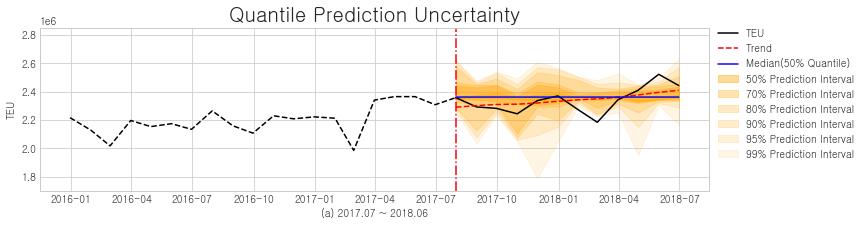

In [46]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(a) 2017.07 ~ 2018.06')
plt.ylabel('TEU')
plt.title('Quantile Prediction Uncertainty',fontsize=20)
plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[191:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:222], 'black', label='TEU')
plt.plot(trend.head(12),color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='orange', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='orange', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='orange', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='orange', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='orange', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='orange', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.head(12).reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.head(12).reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.head(12).reset_index()['TEU'])*100) )

In [47]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(12).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.head(12).reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.75
추세 변동에 대한 포함확률: 0.5833333333333334


In [48]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 156950.55
Quantile 70% Interval Sharpness 80247.32916666672


In [49]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(12).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.75


In [50]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 313901.03
Quantile 95% Interval Sharpness 299260.871875
Min Max Interval Sharpness 416181.22


In [51]:
import CRPS.CRPS as pscore

In [52]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.head(12).reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

8466.480277777777
57887.43069444445
67912.81222222222
85205.61708333333
22978.88444444444
12720.505138888888
83495.56194444445
147015.1958333333
15028.052777777777
32544.804861111115
127565.61444444445
49737.80777777778


In [53]:
a = np.array([8466.480277777777,
57887.43069444445,
67912.81222222222,
85205.61708333333,
22978.88444444444,
12720.505138888888,
83495.56194444445,
147015.1958333333,
15028.052777777777,
32544.804861111115,
127565.61444444445,
49737.80777777778])

In [54]:
np.mean(a)

59213.230625

In [55]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2365097.2

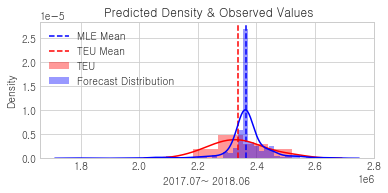

In [56]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.head(12).mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.head(12).reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2017.07~ 2018.06')
plt.legend(loc=2)

In [57]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.head(12).reset_index()['TEU'].mean(), scale=test_data.head(12).reset_index()['TEU'].std() ) )
LL

4607.671834344699

In [58]:
LL = -np.sum( stats.norm.logpdf(test_data.head(12).reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

333.50542461918815

In [59]:
def KL(p,q):
    return(np.abs(sum(p*np.log(p/q))))

In [60]:
for i in range(0,30):
    print(KL(df[i],test_data.head(12).reset_index()['TEU']))

658574.6199036926
550334.5435601587
634863.8339452981
130775.3042269564
52399.384624326034
111106.65112621048
113565.23479801275
402731.62590195553
266741.69209415274
428742.89273661963
388983.88829719124
552685.3583013659
343855.67143368325
22189.18231121407
660025.5406040122
214618.5041812545
358993.9814720511
466257.25350048573
386099.3776088199
637303.9707196834
788141.7631271759
273659.54944663343
852647.8420994126
181234.92879064364
504993.624807504
636019.3615892639
292297.96185828
373707.78206788655
169925.09237345937
516641.09507804614


In [61]:
a = np.array([658574.6199036926,
550334.5435601587,
634863.8339452981,
130775.3042269564,
52399.384624326034,
111106.65112621048,
113565.23479801275,
402731.62590195553,
266741.69209415274,
428742.89273661963,
388983.88829719124,
552685.3583013659,
343855.67143368325,
22189.18231121407,
660025.5406040122,
214618.5041812545,
358993.9814720511,
466257.25350048573,
386099.3776088199,
637303.9707196834,
788141.7631271759,
273659.54944663343,
852647.8420994126,
181234.92879064364,
504993.624807504,
636019.3615892639,
292297.96185828,
373707.78206788655,
169925.09237345937,
516641.09507804614])

In [62]:
np.mean(a)

399003.91708618164

### 2. 2018.07 ~ 2019.06

In [63]:
X_test_2 = np.array(feature_test[12:30]).reshape((1, 18, 10)) 

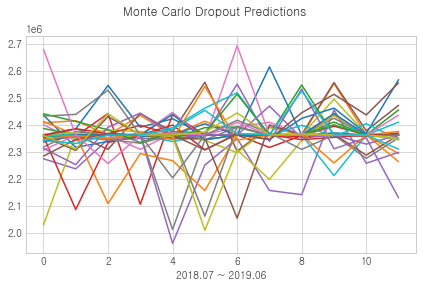

In [64]:
model_MC=  model
prediction = [model_MC.predict(X_test_2) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2018.07 ~ 2019.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [65]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [66]:
np.mean(df.std()/df.mean())

0.030910680070519447

In [67]:
df.to_csv('TCN.csv')

In [68]:
rmse = math.sqrt(mean_squared_error(trend[12:24].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[12:24].reset_index()['TEU_Trend']- df.transpose().median())/ trend[12:24].reset_index()['TEU_Trend'])*100) )

RMSE: 79945.40501469633
MAPE: 3.247263487270778


In [69]:
rmse = math.sqrt(mean_squared_error(trend[12:24].reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[12:24].reset_index()['TEU_Trend']- df.transpose().mean())/ trend[12:24].reset_index()['TEU_Trend'])*100) )

RMSE: 80403.02564649904
MAPE: 3.2217503412657216


In [70]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[12:24]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-31,2362557.0,2407208.0,2359194.75,2341740.5,2274433.25,2345968.0,2400531.75,2318098.5,2029341.0,2362565.0,2435904.0,2412651.5,2386497.0,2357478.0,2345941.5,2356021.5,2306226.75,2362560.5,2365331.0,2357440.75,2336109.75,2346253.0,2440819.25,2361081.75,2313147.75,2284381.0,2679097.5,2432291.0,2360690.5,2342980.25


In [71]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:234]
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2019-06-30,2469920,1354,2.840263,2.897122,4.424881,109.8,6166.1,1175.62,140568904,100.79


Mean RMSE: 135569.72682817365
Mean MAPE: 4.968103904364676


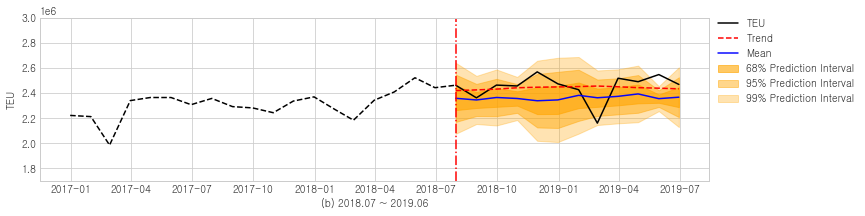

In [72]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2018.07 ~ 2019.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.7e6,3.0e6)
plt.plot(data['TEU'].iloc[203:223], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[222:234], 'black', label='TEU')
plt.plot(trend.iloc[12:24],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2018-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='orange', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='orange', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='orange',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[12:24].reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.iloc[12:24].reset_index()['TEU']- df.transpose().mean())/ test_data.iloc[12:24].reset_index()['TEU'])*100) )

In [73]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[12:24].reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[12:24].reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.6666666666666666
추세 변동에 대한 포함확률: 0.5


Median RMSE: 134659.62082099312
Median MAPE: 4.986071173434379


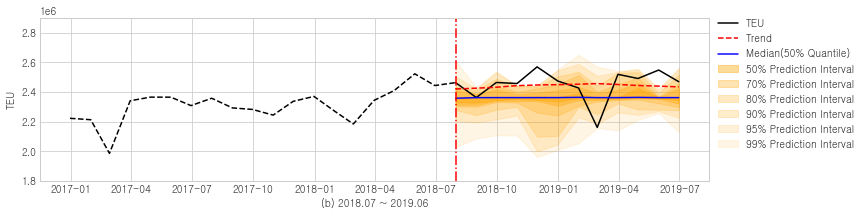

In [74]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(b) 2018.07 ~ 2019.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.8e6,2.9e6)
plt.plot(data['TEU'].iloc[203:223], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[222:234], 'black', label='TEU')
plt.plot(trend.iloc[12:24],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue',alpha=10.0)
plt.axvline(x='2018-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='orange', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='orange', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='orange', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='orange', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='orange', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='orange', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[12:24].reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.iloc[12:24].reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.iloc[12:24].reset_index()['TEU'])*100) )

In [75]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[12:24].reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[12:24].reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.6666666666666666
추세 변동에 대한 포함확률: 0.08333333333333333


In [76]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 156975.95
Quantile 70% Interval Sharpness 71795.22499999998


In [77]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[12:24].reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.75


In [78]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 313951.97
Quantile 95% Interval Sharpness 310017.8479166666
Min Max Interval Sharpness 439127.16


In [79]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.iloc[12:24].reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

78166.67777777779
6349.030277777778
74864.24472222223
77030.57861111112
187144.89347222223
85483.18041666668
37655.0838888889
173113.12083333335
117252.13944444444
68324.95694444442
178257.35444444444
76812.51361111112


In [80]:
a = np.array([78166.67777777779,
6349.030277777778,
74864.24472222223,
77030.57861111112,
187144.89347222223,
85483.18041666668,
37655.0838888889,
173113.12083333335,
117252.13944444444,
68324.95694444442,
178257.35444444444,
76812.51361111112])

In [81]:
np.mean(a)

96704.48120370372

In [82]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2363069.0

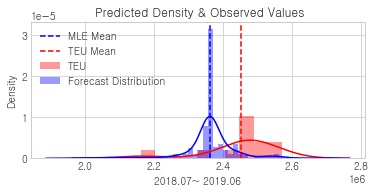

In [83]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.iloc[12:24].mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.iloc[12:24].reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2018.07~ 2019.06')
plt.legend(loc=2)

In [84]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.iloc[12:24].reset_index()['TEU'].mean(), scale=test_data.iloc[12:24].reset_index()['TEU'].std() ) )
LL

4726.687569302372

In [85]:
LL = -np.sum( stats.norm.logpdf(test_data.iloc[12:24].reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

561.8862334830023

In [86]:
for i in range(0,30):
    print(KL(df[i],test_data.iloc[12:24].reset_index()['TEU']))

434337.68269020214
678840.5690697146
875764.5170424009
1143085.3240224256
2160819.763615657
510601.31448700745
966647.1365622225
1417088.8037272105
1203759.4583462349
1131559.9387863753
634945.8055446305
1560038.0681933765
817636.3202727165
1327512.14072005
1020370.0087504156
1338622.9256440995
659364.445762612
1215510.1820775694
1521493.418034824
690937.0712331936
912414.5113770363
976768.3503308666
690965.8889557578
981391.4018717764
987036.6149298359
680370.8118680657
670655.241303435
839314.734281526
910293.8922646089
847014.2264741845


In [87]:
a = np.array([434337.68269020214,
678840.5690697146,
875764.5170424009,
1143085.3240224256,
2160819.763615657,
510601.31448700745,
966647.1365622225,
1417088.8037272105,
1203759.4583462349,
1131559.9387863753,
634945.8055446305,
1560038.0681933765,
817636.3202727165,
1327512.14072005,
1020370.0087504156,
1338622.9256440995,
659364.445762612,
1215510.1820775694,
1521493.418034824,
690937.0712331936,
912414.5113770363,
976768.3503308666,
690965.8889557578,
981391.4018717764,
987036.6149298359,
680370.8118680657,
670655.241303435,
839314.734281526,
910293.8922646089,
847014.2264741845])

In [88]:
np.mean(a)

993505.3522746677

### 3. 2019.07 ~ 2020.06

In [89]:
X_test_3 = np.array(feature_test[24:42]).reshape((1, 18, 10)) 

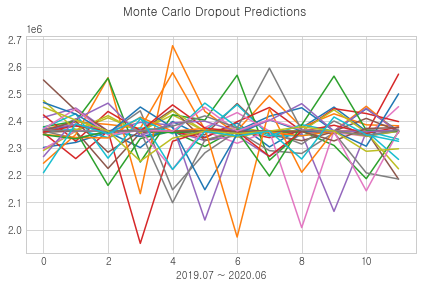

In [90]:
model_MC=  model
prediction = [model_MC.predict(X_test_3) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2019.07 ~ 2020.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [91]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [92]:
np.mean(df.std()/df.mean())

0.03037562035024166

In [93]:
df.to_csv('TCN.csv')

In [94]:
rmse = math.sqrt(mean_squared_error(trend[24:36].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[24:36].reset_index()['TEU_Trend']- df.transpose().median())/ trend[24:36].reset_index()['TEU_Trend'])*100) )

RMSE: 59418.22814574551
MAPE: 2.397451556147571


In [95]:
rmse = math.sqrt(mean_squared_error(trend[24:36].reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[24:36].reset_index()['TEU_Trend']- df.transpose().mean())/ trend[24:36].reset_index()['TEU_Trend'])*100) )

RMSE: 64704.09270982392
MAPE: 2.588673584588402


In [96]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[24:36]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-07-31,2302428.75,2368892.75,2367726.5,2355700.5,2413035.5,2358316.75,2363046.0,2351131.5,2291288.75,2362475.75,2369713.5,2244438.75,2378179.25,2422020.75,2368287.5,2364316.0,2297035.5,2362641.5,2475093.75,2374196.0,2467661.0,2350946.75,2349152.5,2359347.75,2268744.5,2550499.75,2370501.0,2366760.5,2450532.5,2209569.0


In [97]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:246]
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2020-06-30,2371415,1799,2.70092,2.992441,4.411836,110.4,7039.3,1210.01,116998896,95.01


Mean RMSE: 116969.0452998766
Mean MAPE: 3.88541188999833


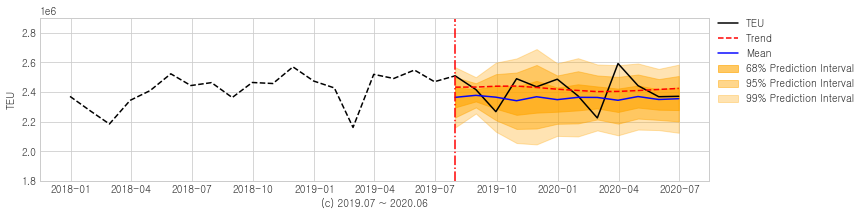

In [98]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(c) 2019.07 ~ 2020.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.8e6,2.9e6)
plt.plot(data['TEU'].iloc[215:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:246], 'black', label='TEU')
plt.plot(trend.iloc[24:36],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='orange', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='orange', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='orange',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[24:36].reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.iloc[24:36].reset_index()['TEU']- df.transpose().mean())/ test_data.iloc[24:36].reset_index()['TEU'])*100) )

In [99]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[24:36].reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[24:36].reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.8333333333333334
추세 변동에 대한 포함확률: 0.75


Median RMSE: 110604.95776195313
Median MAPE: 3.670259789423376


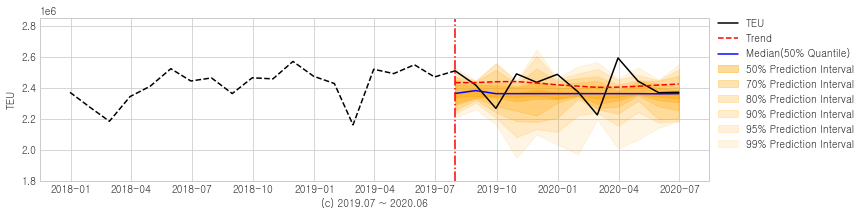

In [100]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(c) 2019.07 ~ 2020.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.8e6,2.85e6)
plt.plot(data['TEU'].iloc[215:235], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[234:246], 'black', label='TEU')
plt.plot(trend.iloc[24:36],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue',alpha=10.0)
plt.axvline(x='2019-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='orange', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='orange', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='orange', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='orange', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='orange', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='orange', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[24:36].reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.iloc[24:36].reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.iloc[24:36].reset_index()['TEU'])*100) )

In [101]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[24:36].reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[24:36].reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.5833333333333334
추세 변동에 대한 포함확률: 0.25


In [102]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 155067.0
Quantile 70% Interval Sharpness 82542.7416666667


In [103]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[24:36].reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.75


In [104]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 310133.9
Quantile 95% Interval Sharpness 301155.15104166657
Min Max Interval Sharpness 422916.9


In [105]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.iloc[24:36].reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

113423.97
23456.766111111116
71087.9788888889
109428.87930555556
43448.360555555555
102351.04541666666
8899.664444444443
102763.43194444446
215995.33819444446
52334.83430555556
9979.911944444444
10630.294444444446


In [106]:
a = np.array([113423.97,
23456.766111111116,
71087.9788888889,
109428.87930555556,
43448.360555555555,
102351.04541666666,
8899.664444444443,
102763.43194444446,
215995.33819444446,
52334.83430555556,
9979.911944444444,
10630.294444444446])

In [107]:
np.mean(a)

71983.37296296297

In [108]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2359359.5

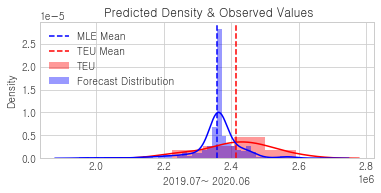

In [109]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.iloc[24:36].mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.iloc[24:36].reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2019.07~ 2020.06')
plt.legend(loc=2)

In [110]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.iloc[24:36].reset_index()['TEU'].mean(), scale=test_data.iloc[24:36].reset_index()['TEU'].std() ) )
LL

4642.904185413285

In [111]:
LL = -np.sum( stats.norm.logpdf(test_data.iloc[24:36].reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

724.9885133512263

In [112]:
for i in range(0,30):
    print(KL(df[i],test_data.iloc[24:36].reset_index()['TEU']))

678477.3442409761
40031.018710199176
1097283.8431708224
917091.8749586162
886713.508876534
877755.1243098674
549724.9613137002
803699.1616672304
563853.5852236453
643717.0133668929
373328.29098027066
264940.0345975348
246092.16456261429
217018.6989677555
726232.4370931964
554657.397151414
998921.6307789308
1370680.1736493302
445287.22172572033
508075.3247729177
424516.9307444345
1000849.6609366225
588241.3516009258
549591.7766263155
350503.16948564973
354926.3143841572
599569.4253389812
266581.1639189285
735095.3303206009
918079.4227203408


In [113]:
a = np.array([678477.3442409761,
40031.018710199176,
1097283.8431708224,
917091.8749586162,
886713.508876534,
877755.1243098674,
549724.9613137002,
803699.1616672304,
563853.5852236453,
643717.0133668929,
373328.29098027066,
264940.0345975348,
246092.16456261429,
217018.6989677555,
726232.4370931964,
554657.397151414,
998921.6307789308,
1370680.1736493302,
445287.22172572033,
508075.3247729177,
424516.9307444345,
1000849.6609366225,
588241.3516009258,
549591.7766263155,
350503.16948564973,
354926.3143841572,
599569.4253389812,
266581.1639189285,
735095.3303206009,
918079.4227203408])

In [114]:
np.mean(a)

618384.5118731707

### 4. 2020.07 ~ 2021.06

In [115]:
X_test_4 = np.array(feature_test[36:54]).reshape((1, 18, 10)) 

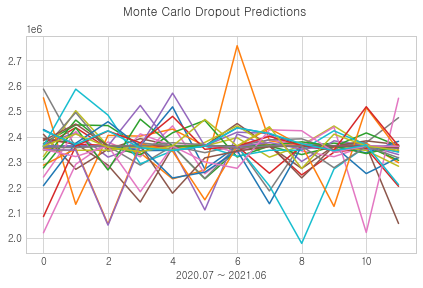

In [116]:
model_MC=  model
prediction = [model_MC.predict(X_test_4) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2020.07 ~ 2021.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [117]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [118]:
np.mean(df.std()/df.mean())

0.03208381310105324

In [119]:
df.to_csv('TCN1.csv')

In [120]:
rmse = math.sqrt(mean_squared_error(trend[36:48].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[36:48].reset_index()['TEU_Trend']- df.transpose().median())/ trend[36:48].reset_index()['TEU_Trend'])*100) )

RMSE: 117599.96364858071
MAPE: 4.550829104542925


In [121]:
rmse = math.sqrt(mean_squared_error(trend[36:48].reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[36:48].reset_index()['TEU_Trend']- df.transpose().mean())/ trend[36:48].reset_index()['TEU_Trend'])*100) )

RMSE: 127970.44412867862
MAPE: 4.916151250964176


In [122]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[36:48]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-07-31,2427609.75,2351008.25,2372374.0,2361077.0,2369387.25,2408632.5,2021160.125,2586448.25,2321312.5,2362374.25,2362457.25,2552379.25,2309497.0,2390178.25,2362407.25,2393185.75,2240683.0,2351812.5,2345565.0,2362780.0,2206738.5,2287194.5,2276278.0,2084837.875,2348005.5,2383955.5,2349447.0,2357085.5,2362231.5,2424006.25


In [123]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data = data.iloc[:258]
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2021-06-30,2507761,3383,3.40973,3.569689,4.537851,117.6,8830.5,1121.3,130920264,107.4


Mean RMSE: 183677.00500950144
Mean MAPE: 6.373773476572048


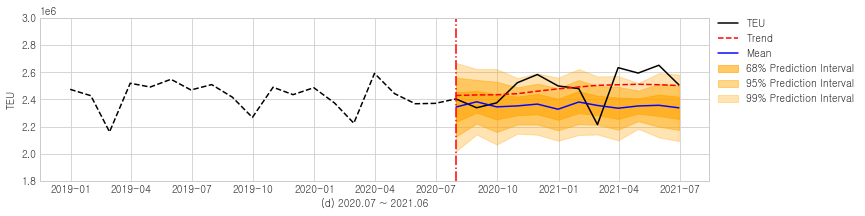

In [124]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(d) 2020.07 ~ 2021.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.8e6,3.0e6)
plt.plot(data['TEU'].iloc[227:247], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[246:258], 'black', label='TEU')
plt.plot(trend.iloc[36:48],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2020-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='orange', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='orange', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='orange',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[36:48].reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.iloc[36:48].reset_index()['TEU']- df.transpose().mean())/ test_data.iloc[36:48].reset_index()['TEU'])*100) )

In [125]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[36:48].reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[36:48].reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.4166666666666667
추세 변동에 대한 포함확률: 0.25


Median RMSE: 174709.01961508623
Median MAPE: 5.957935190152425


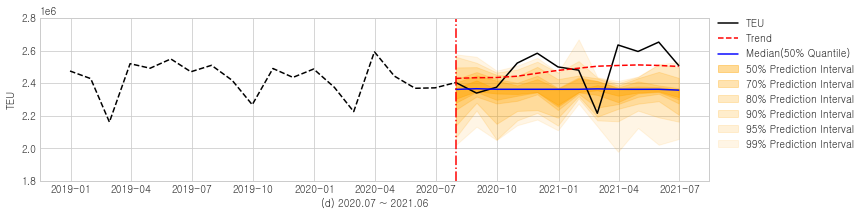

In [126]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(d) 2020.07 ~ 2021.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.8e6,2.8e6)
plt.plot(data['TEU'].iloc[227:247], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[246:258], 'black', label='TEU')
plt.plot(trend.iloc[36:48],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue',alpha=10.0)
plt.axvline(x='2020-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='orange', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='orange', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='orange', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='orange', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='orange', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='orange', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.iloc[36:48].reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.iloc[36:48].reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.iloc[36:48].reset_index()['TEU'])*100) )

In [127]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[36:48].reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.iloc[36:48].reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.4166666666666667
추세 변동에 대한 포함확률: 0.08333333333333333


In [128]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 158144.83
Quantile 70% Interval Sharpness 82011.25104166656


In [129]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.iloc[36:48].reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.5


In [130]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 316289.6
Quantile 95% Interval Sharpness 311183.86249999976
Min Max Interval Sharpness 426223.16


In [131]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.iloc[36:48].reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

32981.48722222222
26040.078611111116
14218.835972222221
139081.60777777777
182069.21444444446
133201.5961111111
86069.29583333334
115386.90194444444
268343.6997222222
217493.77305555556
265389.84319444443
135456.8502777778


In [132]:
a = np.array([32981.48722222222,
26040.078611111116,
14218.835972222221,
139081.60777777777,
182069.21444444446,
133201.5961111111,
86069.29583333334,
115386.90194444444,
268343.6997222222,
217493.77305555556,
265389.84319444443,
135456.8502777778])

In [133]:
np.mean(a)

134644.43201388887

In [134]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2353541.2

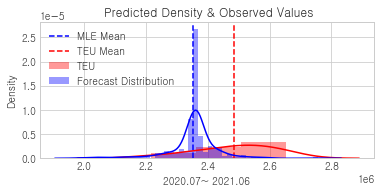

In [135]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.iloc[36:48].mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.iloc[36:48].reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2020.07~ 2021.06')
plt.legend(loc=2)

In [136]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.iloc[36:48].reset_index()['TEU'].mean(), scale=test_data.iloc[36:48].reset_index()['TEU'].std() ) )
LL

4819.924408073272

In [137]:
LL = -np.sum( stats.norm.logpdf(test_data.iloc[36:48].reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

815.146999592178

In [138]:
for i in range(0,30):
    print(KL(df[i],test_data.iloc[36:48].reset_index()['TEU']))

1275194.5811303796
1249152.0012727831
1384665.446306939
1479792.4809134551
1336011.7957086242
1670157.7066108745
1834576.8887024855
1303730.1291841695
1238195.654358133
1940001.287796159
1429345.8950084448
1211713.9512967241
1243389.4833495603
1625721.3710375384
1426121.7324583482
1697092.0528803382
1492145.7724245773
1368143.8247945956
1448148.7291156363
1139362.704215572
1887614.0561370084
2026408.4817700172
1393034.020790803
1303045.8970536208
1511838.9935309342
1509062.8895650092
1639623.928376624
1505085.1777109385
1228734.9972514976
1299771.5125226362


In [139]:
a = np.array([1275194.5811303796,
1249152.0012727831,
1384665.446306939,
1479792.4809134551,
1336011.7957086242,
1670157.7066108745,
1834576.8887024855,
1303730.1291841695,
1238195.654358133,
1940001.287796159,
1429345.8950084448,
1211713.9512967241,
1243389.4833495603,
1625721.3710375384,
1426121.7324583482,
1697092.0528803382,
1492145.7724245773,
1368143.8247945956,
1448148.7291156363,
1139362.704215572,
1887614.0561370084,
2026408.4817700172,
1393034.020790803,
1303045.8970536208,
1511838.9935309342,
1509062.8895650092,
1639623.928376624,
1505085.1777109385,
1228734.9972514976,
1299771.5125226362])

In [140]:
np.mean(a)

1469896.114775814

### 5. 2021.07 ~ 2022.06

In [141]:
X_test_5 = np.array(feature_test[48:66]).reshape((1, 18, 10)) 

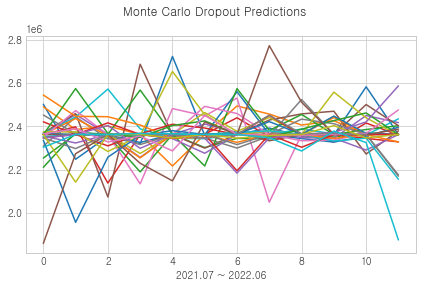

In [142]:
model_MC=  model
prediction = [model_MC.predict(X_test_5) for sample in range(30)]

dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)
    
rcParams['figure.figsize'] = 7, 4
plt.suptitle('Monte Carlo Dropout Predictions')
plt.xlabel('2021.07 ~ 2022.06')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [143]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])
    
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [144]:
np.mean(df.std()/df.mean())

0.03371554985642433

In [145]:
df.to_csv('TCN2.csv')

In [146]:
rmse = math.sqrt(mean_squared_error(trend[48:60].reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[48:60].reset_index()['TEU_Trend']- df.transpose().median())/ trend[48:60].reset_index()['TEU_Trend'])*100) )

RMSE: 139709.2150523284
MAPE: 5.559929046305883


In [147]:
rmse = math.sqrt(mean_squared_error(trend[48:60].reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend[48:60].reset_index()['TEU_Trend']- df.transpose().mean())/ trend[48:60].reset_index()['TEU_Trend'])*100) )

RMSE: 136831.7892837977
MAPE: 5.407595056967444


In [148]:
df2 = pd.read_csv('TEU분해.csv')
df2 = df2.iloc[48:60]
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-31,2502046.0,2490595.75,2253269.0,2362580.0,2362591.0,2370293.5,2362536.5,2308085.25,2362558.5,2366432.0,2366653.25,2362531.0,2210418.75,2421058.75,2355078.0,2362561.75,2349603.0,2452435.0,2374746.75,2352256.75,2335369.25,2545089.0,2361877.75,2346607.0,2346329.75,1858457.75,2365075.25,2346162.5,2361328.5,2303302.25


In [149]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.tail(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2022-06-30,2324505,2240,3.749211,3.625297,4.488265,120.1,5609.8,1277.35,118631016,132.61


Mean RMSE: 151613.90685153674
Mean MAPE: 4.855100837978827


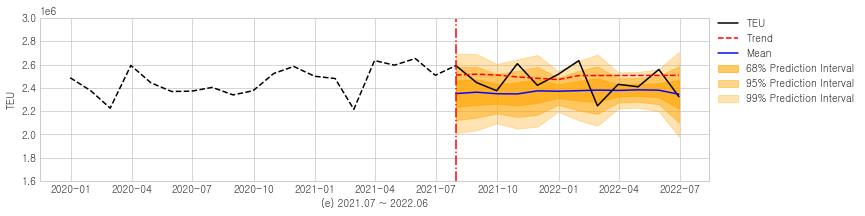

In [150]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(e) 2021.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Gaussian Prediction Uncertainty')
plt.ylim(1.6e6,3.0e6)
plt.plot(data['TEU'].iloc[239:259], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[258:270], 'black', label='TEU')
plt.plot(trend.iloc[48:60],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2021-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='orange', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='orange', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='orange',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.tail(12).reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.tail(12).reset_index()['TEU']- df.transpose().mean())/ test_data.tail(12).reset_index()['TEU'])*100) )

In [151]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(12).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.tail(12).reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.5833333333333334
추세 변동에 대한 포함확률: 0.0


Median RMSE: 152606.67064287138
Median MAPE: 5.006685895466585


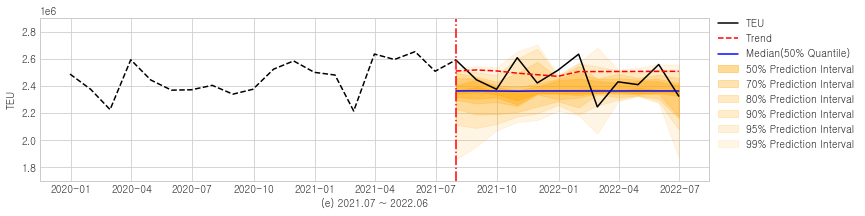

In [152]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('(e) 2021.07 ~ 2022.06')
plt.ylabel('TEU')
#plt.title('Quantile Prediction Uncertainty')
plt.ylim(1.7e6,2.9e6)
plt.plot(data['TEU'].iloc[239:259], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[258:270], 'black', label='TEU')
plt.plot(trend.iloc[48:60],color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue',alpha=10.0)
plt.axvline(x='2021-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='orange', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='orange', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='orange', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='orange', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='orange', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='orange', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.tail(12).reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.tail(12).reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.tail(12).reset_index()['TEU'])*100) )

In [153]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(12).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.tail(12).reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
print('추세 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.5
추세 변동에 대한 포함확률: 0.0


In [154]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 172886.92
Quantile 70% Interval Sharpness 90633.08333333333


In [155]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.tail(12).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
print('전체 변동에 대한 포함확률:',CP)

전체 변동에 대한 포함확률: 0.75


In [156]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,12):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 345773.97
Quantile 95% Interval Sharpness 333092.0937499998
Min Max Interval Sharpness 484875.97


In [157]:
crps = []

for i in range(0,12):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.iloc[48:60].reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

194081.99944444446
44023.43527777777
13583.80263888889
219701.50583333333
45408.16777777779
114408.98666666666
216984.28888888887
108437.21083333333
43355.31861111111
24784.506388888887
150951.37388888886
31034.20763888889


In [158]:
a = np.array([194081.99944444446,
44023.43527777777,
13583.80263888889,
219701.50583333333,
45408.16777777779,
114408.98666666666,
216984.28888888887,
108437.21083333333,
43355.31861111111,
24784.506388888887,
150951.37388888886,
31034.20763888889])

In [159]:
np.mean(a)

100562.90032407407

In [160]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess, df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]
weight

2366311.0

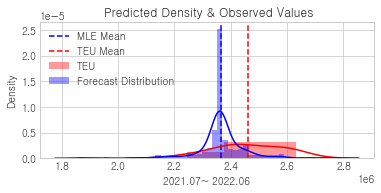

In [161]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.iloc[48:60].mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.iloc[48:60].reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2021.07~ 2022.06')
plt.legend(loc=2)

In [162]:
(3.17+4.99+3.67+5.96+5.00)/5


4.558

In [163]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.iloc[48:60].reset_index()['TEU'].mean(), scale=test_data.iloc[48:60].reset_index()['TEU'].std() ) )
LL

4757.520982749764

In [164]:
LL = -np.sum( stats.norm.logpdf(test_data.iloc[48:60].reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

769.585184021327

In [165]:
for i in range(0,30):
    print(KL(df[i],test_data.iloc[48:60].reset_index()['TEU']))

565361.5328970611
777570.1997099157
1497283.9923808803
1255533.5529149985
989250.1462577631
852207.1806688134
1295296.2154480028
1246118.8669077032
948962.8889506286
759134.6348338273
1023331.9963604943
1132102.5482202363
837920.6704863192
1030535.4477686621
1375127.6244958756
995291.0331301484
886857.0983257332
1025930.8905476503
533661.8734286999
1380639.8518688036
1464560.409679376
854326.4587451126
673331.325301375
1326720.2718241618
1061930.5888351304
1255558.0034041812
1033926.1935533041
1322459.6434544565
1363343.791544628
1743935.2144923965


In [166]:
a = np.array([565361.5328970611,
777570.1997099157,
1497283.9923808803,
1255533.5529149985,
989250.1462577631,
852207.1806688134,
1295296.2154480028,
1246118.8669077032,
948962.8889506286,
759134.6348338273,
1023331.9963604943,
1132102.5482202363,
837920.6704863192,
1030535.4477686621,
1375127.6244958756,
995291.0331301484,
886857.0983257332,
1025930.8905476503,
533661.8734286999,
1380639.8518688036,
1464560.409679376,
854326.4587451126,
673331.325301375,
1326720.2718241618,
1061930.5888351304,
1255558.0034041812,
1033926.1935533041,
1322459.6434544565,
1363343.791544628,
1743935.2144923965])

In [167]:
np.mean(a)

1083607.004881211